In [40]:
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings(action='ignore', category=ConvergenceWarning)
import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm

from sklearn.linear_model import LinearRegression, Lasso, ElasticNet
from sklearn.metrics import mean_squared_error as mse
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures,StandardScaler
from sklearn.model_selection import (validation_curve,
                                     learning_curve,
                                     TimeSeriesSplit,
                                     GridSearchCV,
                                     RandomizedSearchCV)
from sklearn.metrics import r2_score

plt.rcParams['font.size']=12
plt.rcParams['font.family']='Times new roman'
%matplotlib inline

## Get data

In [2]:
#Get data
data = pd.read_csv('master_df.csv', sep = ";")
data["date"] = pd.to_datetime(data["date"]) #Set date to datetime and as index
#data.set_index('date', inplace = True) #set date as index
#data.sort_index(inplace=True)

#Get ticker data
tickers = pd.read_csv("TickerNames_1956.csv")['0'].values

#Create ticker dataframe
index = []
for i in range(len(tickers)):
    index.append(i)
tickers_df = pd.DataFrame({'Index':index, 'Ticker':tickers}).reset_index(drop=True)
tickers_dict = tickers_df['Ticker'].to_dict()

#create tickers dictionary
tickers_dict = {value: key for key, value in tickers_dict.items()}

#drop extra index column
data = data.drop("Unnamed: 0", axis = 1)

# 1. Model: Technical data and eod prices only

### Split and preprocess data

In [37]:
#split data into X and Y
X = data.drop(["returns_pred","Market Cap"], axis = 1)

#get tickers as numbers to differentiate stocks
X['index_ticker']=X['Ticker'].map(tickers_dict)

#drop tickers and sentiment scores
X = X.drop(["Ticker", "LLM_score_sum", "LLM_score_mean"], axis = 1)

y = data["prev_returns"].copy()


In [4]:
X['date'] = pd.to_datetime(X['date'])

#Split the data into development (train & validation) and test
X_dev = X[X['date']<'2023-05-18'] 
X_test = X[X['date']>='2023-05-18']
y_dev =  y[:len(X_dev)]
y_test = y[len(X_dev):]
#sort values by date, descending
X_dev = X_dev.sort_values('date', ascending = True)
X_test = X_test.sort_values('date', ascending = True)

X.set_index('date', inplace = True)
X_dev.set_index('date', inplace = True)
X_test.set_index('date', inplace = True)


In [5]:
tscv = TimeSeriesSplit(n_splits=12, test_size = 19360)

In [6]:
all_train = []
all_val = []

#get index for train and validation splits from the development data
for train_index, val_index in tscv.split(X_dev):
    all_train.append(train_index)
    all_val.append(val_index)

In [7]:
#The data will be trained with folds of 122 for days all companies

No_companies = data['Ticker'].nunique()

print("Training data is splittet in folds of : " ,len(all_train[0])/No_companies, " days")
 # then validated with folds of 10 days for all companies
print("validation data is splittet in folds of : " ,len(all_val[0])/No_companies, " days")
 # at last tested with 11 days for all companies
print("Test data will consist of the last : " ,len(X_test)/No_companies, " days")

Training data is splittet in folds of :  122.0  days
validation data is splittet in folds of :  10.0  days
Test data will consist of the last :  11.0  days


In [8]:
#Symetry 
#There is 1936 companies each day, meaning that the data above is valid for each day and company.
data[["date","Ticker"]].groupby(["date","Ticker"]).value_counts()

#Validate that there is exactly 1936 companies each day
data[["date","Ticker"]].groupby(["Ticker"]).value_counts().sum()==len(data)

True

## Build the model - Lasso and Rigge: ElasticNet

In [9]:
#Create model pipeline

def elasticNet(alpha_, l1):
    pipe_el = make_pipeline(PolynomialFeatures(degree=3, include_bias=False),
                           StandardScaler(),
                           ElasticNet(alpha = alpha_, l1_ratio = l1))
    return pipe_el

Let's test a simple model

In [24]:
start = time.time()
#testing a simple model:
el_test = elasticNet(0.001, 0.3)

model = el_test.fit(X_dev, y_dev)
ypred_dev = model.predict(X_dev)
ypred_test = model.predict(X_test)

print('MSE dev: ', mse(y_dev, ypred_dev))
print('MSE test', mse(y_test, ypred_test))

end = time.time()

elapsed_time = end-start
time_min = elapsed_time/60
time_h = time_min/60
print("Time elapsed(min): ",time_min)

MSE dev:  21.39463033017284
MSE test 26.68862164425312
Time elapsed(min):  0.0


Now lets try cross validation with timeseries!
To do this we will use the timeseries split calculated in the chapter before.

The idea is to start training the model with 122 days data and afterwards validate it with 10 days data.
After that the 10 days are added to the first 122 and the model is now trained with 132 days data.
We'll keep ongoing until all the development data is used to train the model. At last we can use the test data to test our model.

For simplicity here, we will begin by testing through 10 different lambda values with a fixed l1 ratio. After that we will finally try to optimize the model with randomized search.

In [11]:
lambdas = np.logspace(-4,2,10)
start = time.time()
#training the model with time series cross validation

MSE = []
index_i = []
index_j = []
y_predictions = []

for i in tqdm(range(len(lambdas))):
    MSE_ = []
    index_i.append(i)
    for j in range(len(all_train)):
        index_j.append(j)
        pipe_el = make_pipeline(PolynomialFeatures(degree=3, include_bias=False),
                       StandardScaler(),
                       ElasticNet(alpha = 0.01, l1_ratio = lambdas))
        
        #split into 12-folds split by timeseries
        X_train, y_train = X_dev.iloc[all_train[j]], y_dev[all_train[j]]
        X_val, y_val = X_dev.iloc[all_val[j]], y_dev[all_val[j]]
        
        #train the model with the given set
        model = pipe_el.fit(X_train, y_train)
        
        #predict with validation set and find MSE
        
        ypred_val = model.predict(X_val)
        y_predictions.append(ypred_val)
        MSE_.append(mse(y_val, ypred_val))
    MSE.append(np.mean(MSE_))

end = time.time()
elapsed_time = end-start
time_min = elapsed_time/60
time_h = time_min/60
print(time_min)
print("Time elapsed(min): ",time_min)

100%|██████████| 10/10 [1:30:15<00:00, 541.55s/it]  

90.25791155894598
Time elapsed(min):  90.25791155894598


### Gridsearch for optimization

Remember to defined the splits manually before using gridsearch. Save these in a list and feed them to the GridSearch function

In [11]:
tscv = TimeSeriesSplit(n_splits=12, test_size = 19360)
lambdas = np.logspace(-4,2,10)
l2 = np.linspace(0,1,10)

pipe_el = make_pipeline(PolynomialFeatures(degree=3, include_bias=False),
                       StandardScaler(),
                       ElasticNet())

start = time.time()

gs = GridSearchCV(estimator=pipe_el,
                 param_grid={'elasticnet__alpha': l2,
                            'elasticnet__l1_ratio':lambdas},
                 scoring = 'neg_mean_squared_error',
                 cv=tscv)

grid_model = gs.fit(X_dev,y_dev)

end = time.time()

elapsed_time = end - start
time_min = elapsed_time/60
time_h = time_min/60

print("Time elapsed(min): ",time_min)

C:\Users\sebas\anaconda3\Lib\site-packages\sklearn\pipeline.py:405: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\sebas\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
C:\Users\sebas\anaconda3\Lib\site-packages\sklearn\pipeline.py:405: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\sebas\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
C:\Users\sebas\anaconda3

NameError: name 'end_time' is not defined

In [12]:
gs.best_params_

{'elasticnet__alpha': 0.5555555555555556,
 'elasticnet__l1_ratio': 0.046415888336127774}

In [11]:
l1_opt = 0.046415888336127774 #get optimal values from gridsearch
l2_opt =  0.5555555555555556 #get optimal values from gridsearch

In [20]:
coef= pd.DataFrame(gs.best_estimator_.steps[2][1].coef_) # extract coeffiecients from model
coef.to_csv('Coefficients no sentiment optimal.csv')

Now it's time to test the best parameter with the 11-days test data

### Learning curve

We use the learning curve to see wheter our model is over- or underfitting our data. Also it is very useful to consider wheter more data is necessary or not.

In [34]:
pipe_el = make_pipeline(PolynomialFeatures(degree=3, include_bias=False),
                       StandardScaler(),
                       ElasticNet(alpha = l2_opt, l1_ratio = l1_opt))

train_sizes, train_scores, test_scores = \
    learning_curve(estimator = pipe_el,
                  X=X_dev,
                  y=y_dev,
                  train_sizes=np.arange(0.05, 1.05, .05),
                  scoring = 'neg_mean_squared_error',
                  cv=tscv)

mse_ = pd.DataFrame({
    'Train':-train_scores.mean(axis=1),
    'Test':-test_scores.mean(axis=1)})\
    .set_index(pd.Index(train_sizes, name='sample size'))

mse_.head(5)

,Train,Test
sample size,,
11809,16.269647,18.561994
23619,17.041130,18.463960
35428,19.192700,18.951818
47238,21.312473,18.490381
59048,19.933072,18.455987


In [105]:
mse_.to_csv('learning curve data no sentiment.csv')

Plot results

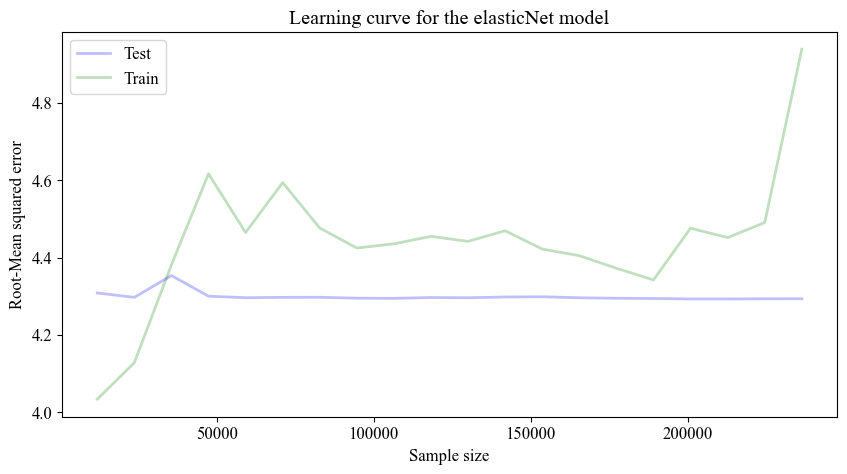

In [53]:
mse_.to_csv('learning curve data no sentiment.csv')
fig, ax = plt.subplots(figsize=(10,5))
ax.plot(train_sizes, np.sqrt(-test_scores.mean(1)), alpha = 0.25, linewidth=2, label = 'Test', color = 'blue')
ax.plot(train_sizes, np.sqrt(-train_scores.mean(1)), alpha = 0.25, linewidth=2, label = 'Train', color = 'green')

ax.set_title('Learning curve for the elasticNet model')
ax.set_ylabel('Root-Mean squared error')
ax.set_xlabel('Sample size')
ax.legend()
plt.savefig('Learning curve elasticnet.png')

### Validation curve

For lasso - l1 ratio

In [66]:
pipe_el = make_pipeline(PolynomialFeatures(degree=3, include_bias = False),
                       StandardScaler(),
                       ElasticNet(alpha = l2_opt))
start = time.time()
lambdas = np.logspace(-4,1,5)

train_scores, val_scores = \
    validation_curve(estimator = pipe_el,
                    X=X_dev,
                    y=y_dev,
                    param_name='elasticnet__l1_ratio',
                    param_range = lambdas,
                    scoring='neg_mean_squared_error',
                    cv=tscv)

#Obtain MSE for different lambdas and print best
mse_score = pd.DataFrame({'Train':-train_scores.mean(axis=1),
                         'Validation':-val_scores.mean(axis=1),
                         'lambda':lambdas})\
            .set_index('lambda')

print(mse_score.Validation.nsmallest(1))

KeyboardInterrupt: 

In [103]:
-train_scores.mean(axis=1)

array([16.26964708, 17.04113013, 19.19269989, 21.31247287, 19.93307225,
       21.10112329, 20.03689144, 19.57776478, 19.67208378, 19.84455211,
       19.72941957, 19.97272528, 19.55280629, 19.4024973 , 19.11668457,
       18.85379306, 20.03288888, 19.81596666, 20.16391898, 24.39009022])

In [67]:
mse_score

,lambda,Train,Validation
0,0.000100,22.759936,18.477271
1,0.000359,22.760064,18.473054
2,0.001292,22.760521,18.461088
3,0.004642,22.762034,18.451714
4,0.016681,22.765242,18.447624
5,0.059948,22.770099,18.445917
6,0.215443,22.782386,18.453967
7,0.774264,22.784452,18.454329
8,2.782559,NaN,NaN
9,10.000000,NaN,NaN


In [116]:
mse_score.to_csv('validation_technical_L1Lasso.csv')

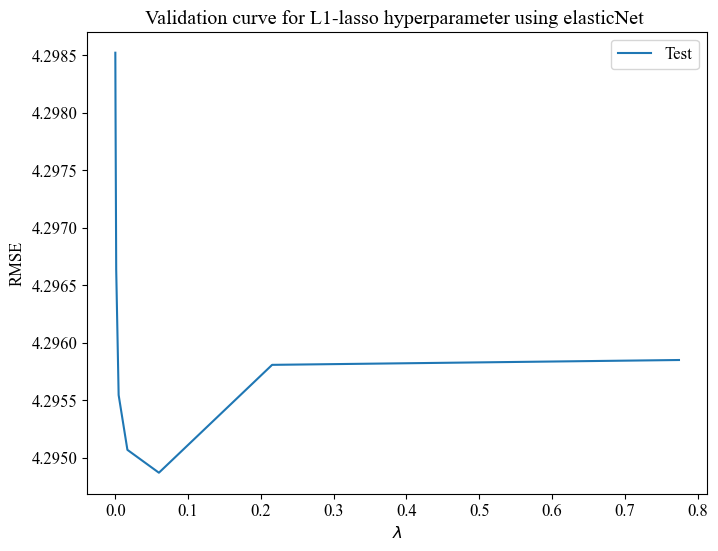

In [117]:

plt.figure(figsize = (8,6))
#plt.plot(mse_score['lambda'],np.sqrt(mse_score['Train']), label = "Train")
plt.plot(mse_score['lambda'],np.sqrt(mse_score['Validation']), label = 'Test')
plt.ylabel('RMSE')
plt.xlabel(r'$\lambda$')
plt.title("Validation curve for L1-lasso hyperparameter using elasticNet ")
plt.legend()
#plt.yscale('log')
plt.savefig('Validation curve for L1-Lasso hyperparameter')

For ridge - l2 ratio

In [146]:
pipe_el = make_pipeline(PolynomialFeatures(degree=3, include_bias = False),
                       StandardScaler(),
                       ElasticNet(l1_ratio=l1_opt))

lambdas = np.linspace(0,1,10)

train_scores2, val_scores2 = \
    validation_curve(estimator = pipe_el,
                    X=X_dev,
                    y=y_dev,
                    param_name='elasticnet__alpha',
                    param_range = lambdas,
                    scoring='neg_mean_squared_error',
                    cv=tscv)

#Obtain MSE for different lambdas and print best
mse_score2 = pd.DataFrame({'Train':-train_scores2.mean(axis=1),
                         'Validation':-val_scores2.mean(axis=1),
                         'lambda':lambdas})\
            .set_index('lambda')

print(mse_score.Validation.nsmallest(1))

C:\Users\sebas\anaconda3\Lib\site-packages\sklearn\pipeline.py:405: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\sebas\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
C:\Users\sebas\anaconda3\Lib\site-packages\sklearn\pipeline.py:405: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\sebas\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
C:\Users\sebas\anaconda3

5    18.445917
Name: Validation, dtype: float64


In [148]:
mse_score2.to_csv('Validation_technical_L2Ridge.csv', index = False)
mse_score2.reset_index(inplace=True)

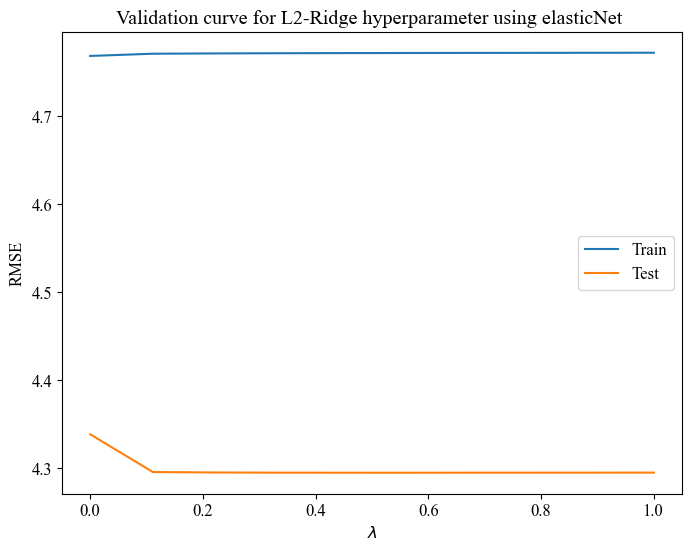

In [152]:
plt.figure(figsize = (8,6))
plt.plot(mse_score2['lambda'],np.sqrt(mse_score2['Train']), label = "Train")
plt.plot(mse_score2['lambda'],np.sqrt(mse_score2['Validation']), label = 'Test')
plt.ylabel('RMSE')
plt.xlabel(r'$\lambda$')
plt.title("Validation curve for L2-Ridge hyperparameter using elasticNet ")
plt.legend()

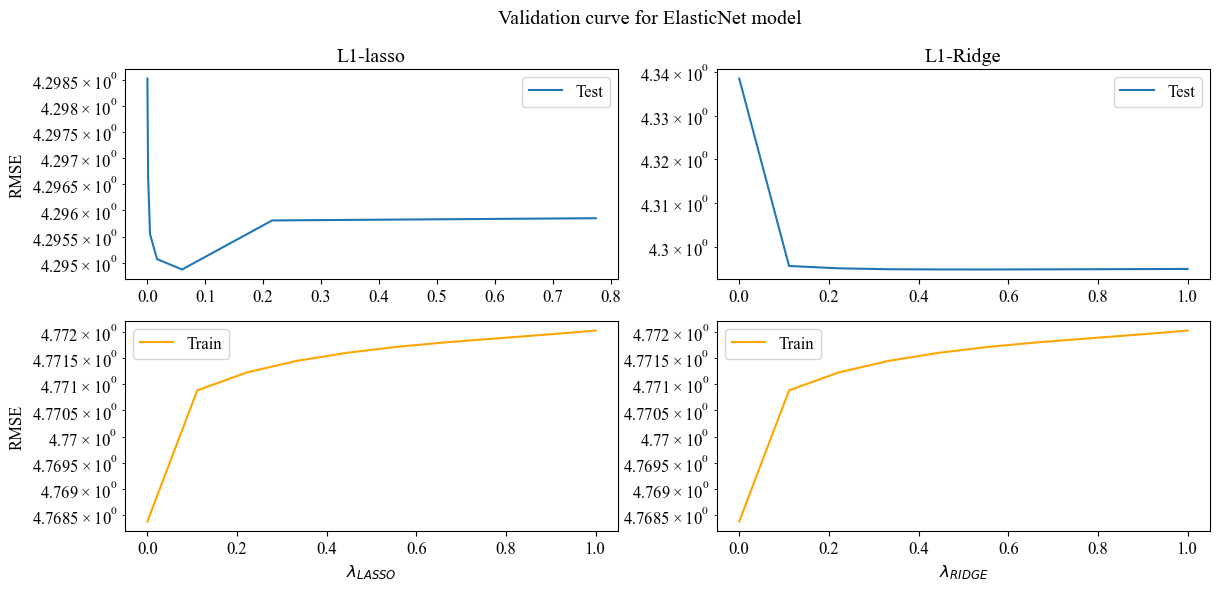

In [158]:
fig, ax = plt.subplots(2,2, figsize=(14,6))

#ax[0][0].plot(mse_score['lambda'],np.sqrt(mse_score['Train']), label = "Train")
ax[0][0].plot(mse_score['lambda'],np.sqrt(mse_score['Validation']), label = 'Test')
ax[0][0].set_ylabel('RMSE')
ax[0][0].set_title("L1-lasso")
ax[0][0].legend()
ax[0][0].set_yscale('log')

#ax[0][1].plot(mse_score['lambda'],np.sqrt(mse_score['Train']), label = "Train")
ax[0][1].plot(mse_score2['lambda'],np.sqrt(mse_score2['Validation']), label = 'Test')
ax[0][1].set_title("L1-Ridge")
ax[0][1].legend()
ax[0][1].set_yscale('log')

ax[1][0].plot(mse_score2['lambda'],np.sqrt(mse_score2['Train']), label = "Train", color ='orange')
#ax[1][0].plot(mse_score2['lambda'],np.sqrt(mse_score2['Validation']), label = 'Test')
ax[1][0].set_ylabel('RMSE')
ax[1][0].set_xlabel(r'$\lambda_{LASSO}$')
ax[1][0].legend()
ax[1][0].set_yscale('log')

ax[1][1].plot(mse_score2['lambda'],np.sqrt(mse_score2['Train']), label = "Train", color ='orange')
#ax[1][1].plot(mse_score2['lambda'],np.sqrt(mse_score2['Validation']), label = 'Test')
ax[1][1].set_xlabel(r'$\lambda_{RIDGE}$')
ax[1][1].legend()
ax[1][1].set_yscale('log')

fig.suptitle("Validation curve for ElasticNet model")

plt.savefig('Validation curve ElasticNet.png')

# 2. Eod-prices, technical data and sentiment data from news headlines

## Get data
Notice that the only difference here is that we now take LLM-score as a feature

In [42]:
#Get data
data = pd.read_csv('master_df.csv', sep = ";")
data["date"] = pd.to_datetime(data["date"]) #Set date to datetime and as index
#data.set_index('date', inplace = True) #set date as index
#data.sort_index(inplace=True)

#Get ticker data

tickers = pd.read_csv("TickerNames_1956.csv")['0'].values

#Create ticker dataframe
index = []
for i in range(len(tickers)):
    index.append(i)
tickers_df = pd.DataFrame({'Index':index, 'Ticker':tickers}).reset_index(drop=True)
tickers_dict = tickers_df['Ticker'].to_dict()

#create tickers dictionary
tickers_dict = {value: key for key, value in tickers_dict.items()}

#drop extra index column
data = data.drop("Unnamed: 0", axis = 1)

In [43]:
#split data into X and Y
X = data.drop(["returns_pred","Market Cap"], axis = 1)

#get tickers as numbers to differentiate stocks
X['index_ticker']=X['Ticker'].map(tickers_dict)

#drop tickers and sentiment scores
X = X.drop(["Ticker"], axis = 1)

y = data["prev_returns"].copy()

In [44]:
X['date'] = pd.to_datetime(X['date'])

#Split the data into development (train & validation) and test
X_dev = X[X['date']<'2023-05-18'] 
X_test = X[X['date']>='2023-05-18']
y_dev =  y[:len(X_dev)]
y_test = y[len(X_dev):]
#sort values by date, descending
X_dev = X_dev.sort_values('date', ascending = True)
X_test = X_test.sort_values('date', ascending = True)

X.set_index('date', inplace = True)
X_dev.set_index('date', inplace = True)
X_test.set_index('date', inplace = True)

In [45]:
tscv = TimeSeriesSplit(n_splits=12, test_size = 19360)

In [46]:
all_train = []
all_val = []

#get index for train and validation splits from the development data
for train_index, val_index in tscv.split(X_dev):
    all_train.append(train_index)
    all_val.append(val_index)

In [47]:
#The data will be trained with folds of 122 for days all companies

No_companies = data['Ticker'].nunique()

print("Training data is splittet in folds of : " ,len(all_train[0])/No_companies, " days")
 # then validated with folds of 10 days for all companies
print("validation data is splittet in folds of : " ,len(all_val[0])/No_companies, " days")
 # at last tested with 11 days for all companies
print("Test data will consist of the last : " ,len(X_test)/No_companies, " days")

Training data is splittet in folds of :  122.0  days
validation data is splittet in folds of :  10.0  days
Test data will consist of the last :  11.0  days


In [48]:
#Symetry check
#There is 1936 companies each day, meaning that the data above is valid for each day and company.
data[["date","Ticker"]].groupby(["date","Ticker"]).value_counts()

#Validate that there is exactly 1936 companies each day
data[["date","Ticker"]].groupby(["Ticker"]).value_counts().sum()==len(data)

True

## Build the model - Lasso and Ridge: ElasticNet

In [9]:
#Create model pipeline

def elasticNet(alpha_, l1):
    pipe_el = make_pipeline(PolynomialFeatures(degree=3, include_bias=False),
                           StandardScaler(),
                           ElasticNet(alpha = alpha_, l1_ratio = l1))
    return pipe_el

Let's test a simple model

In [24]:
start = time.time()
#testing a simple model:
el_test = elasticNet(0.001, 0.3)

model = el_test.fit(X_dev, y_dev)
ypred_dev = model.predict(X_dev)
ypred_test = model.predict(X_test)

print('MSE dev: ', mse(y_dev, ypred_dev))
print('MSE test', mse(y_test, ypred_test))

end = time.time()

elapsed_time = end-start
time_min = elapsed_time/60
time_h = time_min/60
print("Time elapsed(min): ",time_min)

MSE dev:  21.39463033017284
MSE test 26.68862164425312
Time elapsed(min):  0.0


### Gridsearch for optimization

Remember to defined the splits manually before using gridsearch. Save these in a list and feed them to the GridSearch function

In [29]:
tscv = TimeSeriesSplit(n_splits=12, test_size = 19360)
lambdas = np.logspace(-4,2,10)
l2 = np.linspace(0,1,10)

pipe_el = make_pipeline(PolynomialFeatures(degree=3, include_bias=False),
                       StandardScaler(),
                       ElasticNet())


start = time.time()

gs = GridSearchCV(estimator=pipe_el,
                 param_grid={'elasticnet__alpha': l2,
                            'elasticnet__l1_ratio':lambdas},
                 scoring = 'neg_mean_squared_error',
                 cv=tscv)

grid_model = gs.fit(X_dev,y_dev)

end = time.time()

elapsed_time = end - start
time_min = elapsed_time/60
time_h = time_min/60

print("Time elapsed(min): ",time_min)


C:\Users\sebas\anaconda3\Lib\site-packages\sklearn\pipeline.py:405: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\sebas\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
C:\Users\sebas\anaconda3\Lib\site-packages\sklearn\pipeline.py:405: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\sebas\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
C:\Users\sebas\anaconda3

KeyboardInterrupt: 

In [30]:
gs.best_params_

AttributeError: 'GridSearchCV' object has no attribute 'best_params_'

In [49]:
pipe_el = make_pipeline(PolynomialFeatures(degree=3, include_bias=False),
                       StandardScaler(),
                       ElasticNet(alpha = l2_opt, l1_ratio = l1_opt))

train_sizes, train_scores, test_scores = \
    learning_curve(estimator = pipe_el,
                  X=X_dev,
                  y=y_dev,
                  train_sizes=np.arange(0.05, 1.05, .05),
                  scoring = 'neg_mean_squared_error',
                  cv=tscv)

mse_2 = pd.DataFrame({
    'Train':-train_scores.mean(axis=1),
    'Test':-test_scores.mean(axis=1)})\
    .set_index(pd.Index(train_sizes, name='sample size'))

mse_2.head(5)
mse_2.to_csv('learning curve data no sentiment.csv')

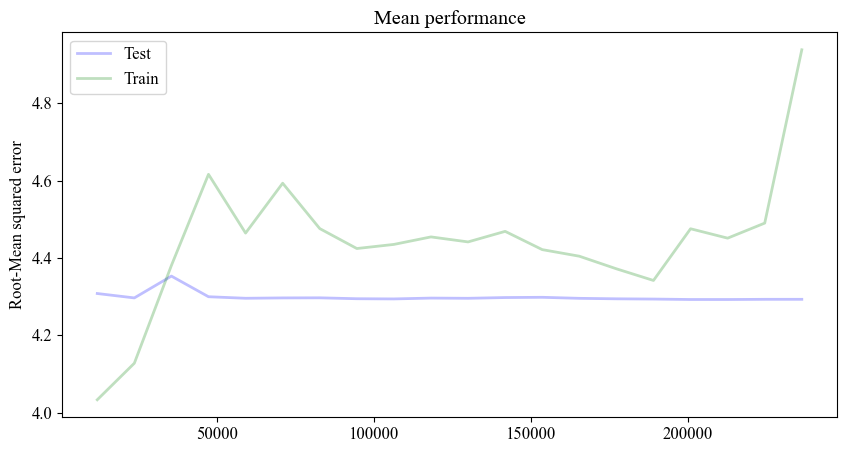

In [50]:
fig, ax = plt.subplots(figsize=(10,5))
ax.plot(train_sizes, np.sqrt(-test_scores.mean(1)), alpha = 0.25, linewidth=2, label = 'Test', color = 'blue')
ax.plot(train_sizes, np.sqrt(-train_scores.mean(1)), alpha = 0.25, linewidth=2, label = 'Train', color = 'green')

ax.set_title('Mean performance')
ax.set_ylabel('Root-Mean squared error')
ax.legend();

# 3. Sentiment data only

## Get data

In [61]:
#Get data
data = pd.read_csv('master_df.csv', sep = ";")
data["date"] = pd.to_datetime(data["date"]) #Set date to datetime and as index
#data.set_index('date', inplace = True) #set date as index
#data.sort_index(inplace=True)

#Get ticker data
tickers = pd.read_csv("TickerNames_1956.csv")['0'].values

#Create ticker dataframe
index = []
for i in range(len(tickers)):
    index.append(i)
tickers_df = pd.DataFrame({'Index':index, 'Ticker':tickers}).reset_index(drop=True)
tickers_dict = tickers_df['Ticker'].to_dict()

#create tickers dictionary
tickers_dict = {value: key for key, value in tickers_dict.items()}

#drop extra index column
data = data.drop("Unnamed: 0", axis = 1)

In [62]:
#split data into X and Y
X = data.drop(["returns_pred","Market Cap"], axis = 1)

#get tickers as numbers to differentiate stocks
X['index_ticker']=X['Ticker'].map(tickers_dict)

X=X[['date','index_ticker','LLM_score_mean','LLM_score_sum']]

#drop tickers and sentiment scores

y = data["prev_returns"].copy()


In [63]:
X['date'] = pd.to_datetime(X['date'])

#Split the data into development (train & validation) and test
X_dev = X[X['date']<'2023-05-18'] 
X_test = X[X['date']>='2023-05-18']
y_dev =  y[:len(X_dev)]
y_test = y[len(X_dev):]
#sort values by date, descending
X_dev = X_dev.sort_values('date', ascending = True)
X_test = X_test.sort_values('date', ascending = True)

X.set_index('date', inplace = True)
X_dev.set_index('date', inplace = True)
X_test.set_index('date', inplace = True)


In [64]:
tscv = TimeSeriesSplit(n_splits=12, test_size = 19360)

In [77]:
all_train = []
all_val = []

#get index for train and validation splits from the development data
for train_index, val_index in tscv.split(X_dev):
    all_train.append(train_index)
    all_val.append(val_index)

In [66]:
#The data will be trained with folds of 122 for days all companies

No_companies = data['Ticker'].nunique()

print("Training data is splittet in folds of : " ,len(all_train[0])/No_companies, " days")
 # then validated with folds of 10 days for all companies
print("validation data is splittet in folds of : " ,len(all_val[0])/No_companies, " days")
 # at last tested with 11 days for all companies
print("Test data will consist of the last : " ,len(X_test)/No_companies, " days")

Training data is splittet in folds of :  122.0  days
validation data is splittet in folds of :  10.0  days
Test data will consist of the last :  11.0  days


In [67]:
#Symetry 
#There is 1936 companies each day, meaning that the data above is valid for each day and company.
data[["date","Ticker"]].groupby(["date","Ticker"]).value_counts()

#Validate that there is exactly 1936 companies each day
data[["date","Ticker"]].groupby(["Ticker"]).value_counts().sum()==len(data)

True

## Build the model - Lasso and Rigge: ElasticNet

As we now only have 2 features then it's enough to use a simple OLS. Using Lasso and/or ridge wont be really necessary as we dont risk overfitting with that few features

In [68]:
#Create model pipeline
pipe_lin = make_pipeline(PolynomialFeatures(degree=3, include_bias=False),
                       StandardScaler(),
                       LinearRegression())

### Gridsearch for optimization - not necessary for OLS

As we don't have any parameters in OLS then gridsearch is not necessary. We can directly train and test the model

## Train and test model with sentiment data only

In [78]:
start = time.time()
#training the model with time series cross validation

MSE = []
index_i = []
y_predictions = []

MSE_ = []
for i in range(len(all_train)):
    index_i.append(i)
    pipe_lin = make_pipeline(PolynomialFeatures(degree=3, include_bias=False),
                           StandardScaler(),
                           LinearRegression())

    #split into 12-folds split by timeseries
    X_train, y_train = X_dev.iloc[all_train[i]], y_dev[all_train[i]]
    X_val, y_val = X_dev.iloc[all_val[i]], y_dev[all_val[i]]

    #train the model with the given set
    model = pipe_lin.fit(X_train, y_train)

    #predict with validation set and find MSE
    ypred_val = model.predict(X_val)
    y_predictions.append(ypred_val)
    MSE_.append(mse(y_val, ypred_val))
    
MSE.append(np.mean(MSE_))

end = time.time()
elapsed_time = end-start
time_min = elapsed_time/60
time_h = time_min/60
print(time_min)
print("Time elapsed(min): ",time_min)

0.08699224392573039
Time elapsed(min):  0.08699224392573039


In [79]:
ypred_test=model.predict(X_test)
MSE_test = mse(y_test, ypred_test)
RMSE_test = np.sqrt(MSE_test)
r2_test = r2_score(y_test, ypred_test)

In [81]:
MSE_test

25.675283099083327

In [82]:
RMSE_test

5.0670783592799635

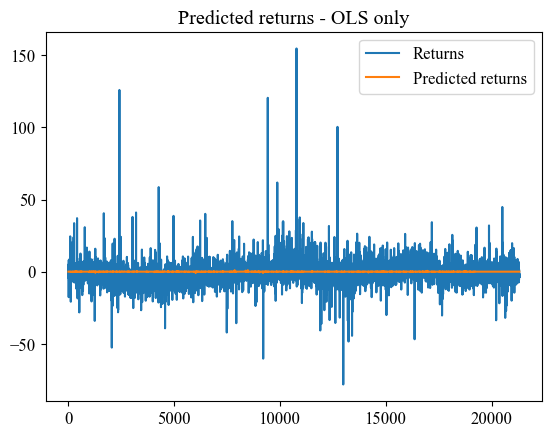

In [84]:
x_ax=np.linspace(0,len(y_test),len(y_test))
plt.figure()
plt.plot(x_ax, y_test, label = "Returns")
plt.plot(x_ax, ypred_test, label = 'Predicted returns')
plt.title("Predicted returns - OLS only")
plt.legend()

### Learning Curve

In [52]:
tscv = TimeSeriesSplit(n_splits=12, test_size = 19360)

In [53]:
pipe_lin = make_pipeline(PolynomialFeatures(degree=3, include_bias=False),
                       StandardScaler(),
                       LinearRegression())

train_sizes, train_scores, test_scores = \
    learning_curve(estimator = pipe_lin,
                  X=X_dev,
                  y=y_dev,
                  train_sizes=np.arange(0.05,1.05,0.05),
                  scoring = 'neg_mean_squared_error',
                  cv = tscv)
mse_ = pd.DataFrame({
    'Train': -train_scores.mean(axis = 1),
    'Test':-test_scores.mean(axis=1)})\
    .set_index(pd.Index(train_sizes, name='sample size'))

mse_.head(5)

,Train,Test
sample size,,
11809,16.324554,59.126996
23619,17.110208,19.996555
35428,19.256793,24.841175
47238,21.340748,24.880957
59048,19.955899,22.808328


In [54]:
mse_.to_csv('learning curve data sentiment only.csv')

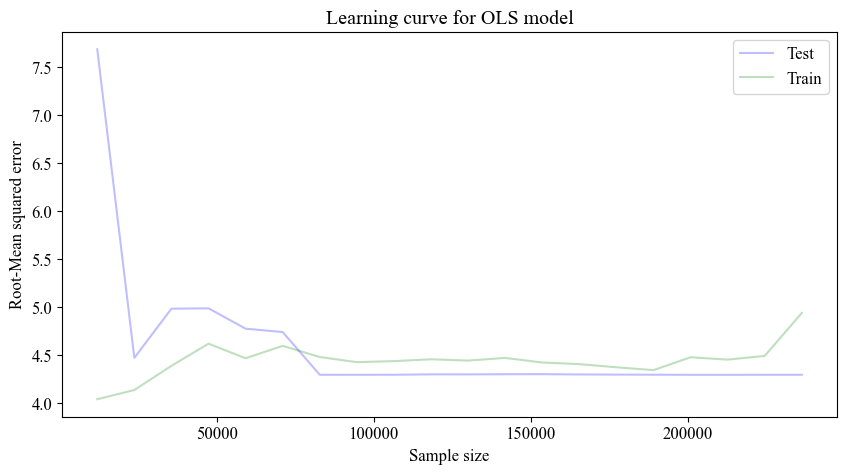

In [59]:
fig, ax = plt.subplots(figsize=(10,5))
ax.plot(train_sizes, np.sqrt(-test_scores.mean(1)), alpha=0.25, label = "Test", color = 'blue')
ax.plot(train_sizes, np.sqrt(-train_scores.mean(1)), alpha = 0.25, label  ='Train', color = 'green')

ax.set_title("Learning curve for OLS model")
ax.set_ylabel("Root-Mean squared error")
ax.set_xlabel('Sample size')
ax.legend()
plt.savefig('Learning curve for OLS model.png')